In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import constants as c
from astropy import units as u
import sys, os, glob
from astropy.io import fits
from matplotlib.patches import Ellipse
import treecorr
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
from pathlib import Path

In [14]:
d0, d1 = -0.006, (0.009 - 0.003j)
a0, a1 = 0.014 - 0.011j, (0.001 - 0.002j)
c0, c1 = -0.039, -0.010

In [9]:
d0, d1 = np.random.normal(-0.006, 0.053), (np.random.normal(0.009, 0.038) - np.random.normal(-0.003, 0.040)*1j)
a0, a1 = (np.random.normal(0.014, 0.099) - np.random.normal(-0.011, 0.089)*1j), \
            (np.random.normal(0.001, 0.066) - np.random.normal(-0.002, 0.055)*1j)
c0, c1 = np.random.normal(-0.039, 0.109), np.random.normal(-0.010, 0.124)

In [15]:
d = np.vectorize(lambda x, y: d0 + np.real(d1 * (x - 1j * y) / rad))
s = np.vectorize(lambda x, y: 0)

a = np.vectorize(lambda x, y: a0 + a1 * (x + 1j*y) / rad)
a_real, a_imag = np.vectorize(lambda x, y: np.real(a(x, y))), np.vectorize(lambda x, y: np.imag(a(x, y)))

c_real, c_imag = np.vectorize(lambda x, y: c0), np.vectorize(lambda x, y: c1)
c = np.vectorize(lambda x, y: c_real(x, y) + c_imag(x, y) * 1j)

In [16]:
# 3pt stuff
rmin = 0.5
rmax = 20
nr = 10

# 2pt stuff
twoptrmin = 0.5
twoptrmax = 20
bin_size = 0.1
bin_slop = 0.1

rad = 1.2
RA_range = (-rad, rad)
Dec_range = (-rad, rad)
num_den = 1000

coeffs = [d, a_real, a_imag, s, c_real, c_imag, \
         np.vectorize(lambda x, y : np.real(Q(x, y))), \
          np.vectorize(lambda x, y : np.imag(Q(x, y))), lambda x, y : S(x, y)]
# labels = [r"$d$", r"$\Re(a)$", r"$\Im(a) \sim \sqrt{x^2+y^2}$", r"$s$", r"$\Re(c)$", r"$\Im(c)\sim \sqrt{x^2+y^2}$", \
#           r"$\Re(Q)$", r"$\Im(Q)$", r"S"]
labels = [r"$d$", r"$\Re(a)$", r"$\Im(a)$", r"$s$", r"$\Re(c)$", r"$\Im(c)$", \
          r"$\Re(Q)$", r"$\Im(Q)$", r"S"]
thin_gal = 10
alpha = 0.5

In [17]:
num_gal = int(np.abs(num_den * (Dec_range[1] - Dec_range[0]) * (RA_range[1] - RA_range[0])))
print(num_gal)

RAs = np.random.uniform(RA_range[0], RA_range[1], size=num_gal)
Decs = np.random.uniform(Dec_range[0], Dec_range[1], size=num_gal)

def Q(x, y):
    return 4 * (d(x, y) + 4/3 * s(x, y)) * a(x, y) + 1/3 * c(x, y)**2
def S(x, y):
    return 2 * (d(x, y) + 4/3 * s(x, y)) ** 2 \
            + 2 * np.abs(a(x, y))**2 + 2/3 * np.abs(c(x, y))**2 + 4/9 * np.abs(s(x, y))**2
def gamma(x, y):
    return Q(x, y) / S(x, y)

def getLineParameters(xpos, ypos, gamma):
    length, angle = np.abs(gamma), np.angle(gamma)
    return [xpos - np.cos(angle)*length/2, xpos + np.cos(angle)*length/2], \
            [ypos - np.sin(angle)*length/2, ypos + np.sin(angle)*length/2]

print("calculating shear field")
gammas = gamma(RAs, Decs)
e_s = np.abs(gammas*2)
phi_s = np.angle(gammas*2)
a_ep_s = np.sqrt(S(RAs, Decs))
b_ep_s = a_ep_s * np.sqrt(1 - e_s**2)
print(a_ep_s.shape, b_ep_s.shape, e_s.shape, phi_s.shape, np.degrees(phi_s).shape)

rand_coords = np.vstack((RAs, Decs, a_ep_s, b_ep_s, phi_s, gammas)).T
print(rand_coords.shape)

RA_grid, Dec_grid = np.meshgrid(np.linspace(*RA_range), np.linspace(*Dec_range))


5760
calculating shear field
(5760,) (5760,) (5760,) (5760,) (5760,)
(5760, 6)


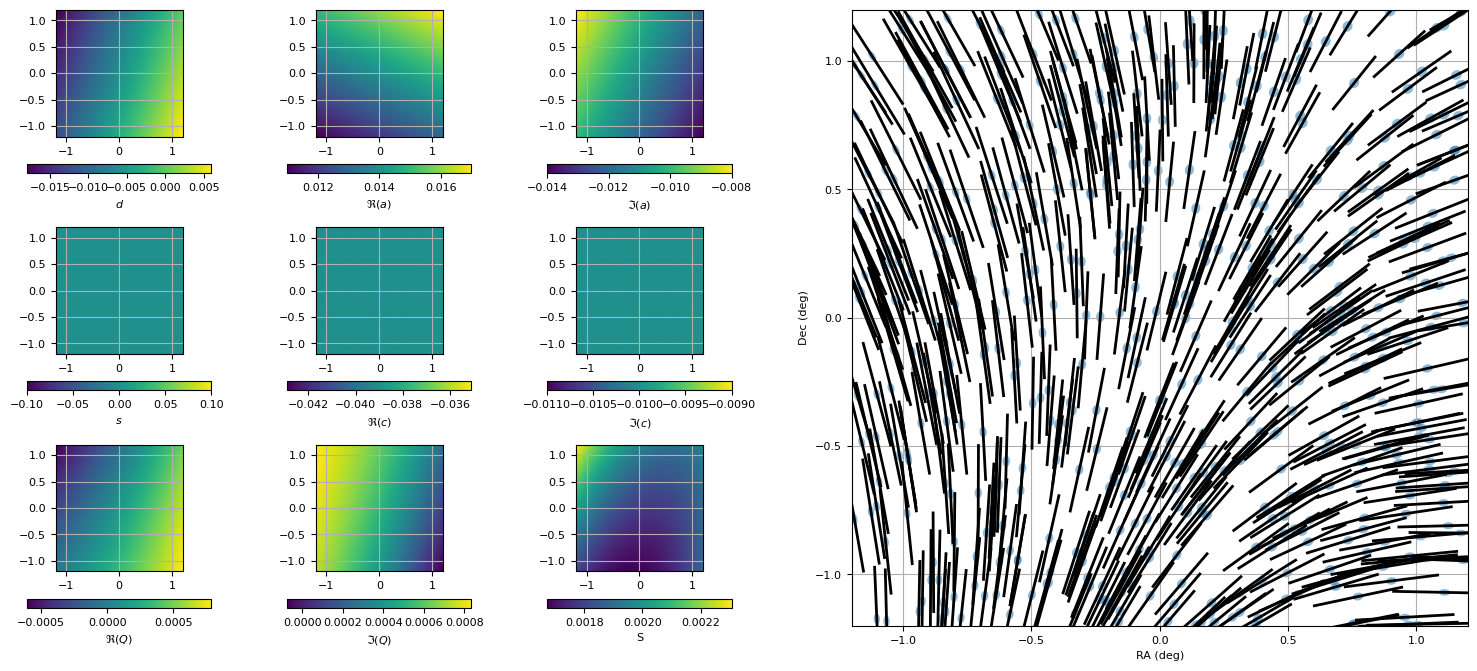

In [18]:
fig = plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 8})
gs = fig.add_gridspec(3, 24)
axs = list(map(fig.add_subplot, [gs[0, 4*y:4*y+3] for y in range(3)] + \
               [gs[1, 4*y:4*y+3] for y in range(3)] + [gs[2, 4*y:4*y+3] for y in range(3)]))
for ax, coeff, label in zip(axs, coeffs, labels):
    f = ax.imshow(coeff(RA_grid, Dec_grid), origin="lower", extent=[*RA_range, *Dec_range])
    cbar = fig.colorbar(f, orientation='horizontal')
    cbar.set_label(label)
    ax.set_aspect('equal')
    ax.grid()

# plot shear field
ax = fig.add_subplot(gs[:, 11:])
for ra, de, a_ep, b_ep, phi, gam in rand_coords[::thin_gal]:
    ra, de, a_ep, b_ep, phi = np.real([ra, de, a_ep, b_ep, phi])
    # Create an ellipse patch with a given size centered at the RA, Dec position
    plt.plot(*getLineParameters(ra, de, gam), color="black", lw=2)
    ellipse = Ellipse(xy=(ra, de), width=a_ep, height=b_ep, angle=np.degrees(phi), alpha=alpha)
    # Add the ellipse patch to the axes
    ax.add_patch(ellipse)

# Show the plot
ax.set_aspect('equal')
ax.grid()
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
plt.xlim(RA_range)
plt.ylim(Dec_range)
plt.show()